# Imports

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import cvxpy as cp
import time
import collections
from typing import Dict
from typing import List
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import imp
import os
import pickle as pk
%matplotlib inline

import sys
sys.path.insert(0, '../../../src/')

import network_utils
import utils

# Helper functions

In [2]:
def reload():
    imp.reload(network_utils)
    imp.reload(utils)
    
def get_array_of_138(a):
    r = a
    if len(a) < 138:
        r = np.array(list(a) + [0 for i in range(138 - len(a))])
    return r

def get_matrix_stochastic(a):
    a = a / np.sum(a)
    return np.matrix(a)

# Body

In [3]:
triad_map, triad_list = network_utils.generate_all_possible_sparse_triads()
unique_triad_num = len(triad_list)

In [4]:
transitives = []
for triad in triad_list:
    transitives.append(network_utils.is_sparsely_transitive_balanced(triad))
transitives = np.array(transitives)

t = np.sum(transitives)
print('{} transitive and {} nontransitive.'.format(t, 138-t))



ch = []
for triad in triad_list:
    ch.append(network_utils.is_sparsely_cartwright_harary_balanced(triad))
ch = np.array(ch)

t = np.sum(ch)
print('{} C&H balance and {} non C&H balance.'.format(t, 138-t))



cluster = []
for triad in triad_list:
    cluster.append(network_utils.is_sparsely_clustering_balanced(triad))
cluster = np.array(cluster)

t = np.sum(cluster)
print('{} clustering balance and {} non C&H balance.'.format(t, 138-t))

93 transitive and 45 nontransitive.
24 C&H balance and 114 non C&H balance.
44 clustering balance and 94 non C&H balance.


### Convex optimization problem

In [5]:
loaded_d = utils.load_it('/home/omid/Downloads/DT/cvx_data.pk')
obs = loaded_d['obs']
T = loaded_d['T']

obs_mat = []
for o in obs:
    obs_mat.append(np.matrix(o))
    
obs_normalized = []
for o in obs:
    obs_normalized.append(get_matrix_stochastic(o))

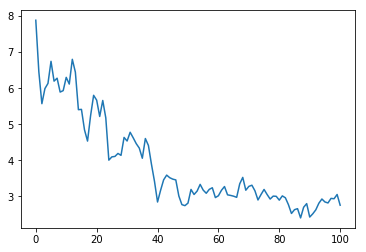

In [17]:
dists = []
for i in range(len(T) - 1):
    dists.append(np.linalg.norm(T[i] - T[i+1]))
plt.plot(dists);

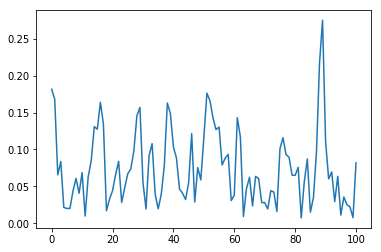

In [18]:
dists = []
for i in range(len(T) - 1):
    st1 = network_utils.get_stationary_distribution(T[i])
    st2 = network_utils.get_stationary_distribution(T[i + 1])
    dists.append(np.linalg.norm(st1 - st2))
plt.plot(dists);

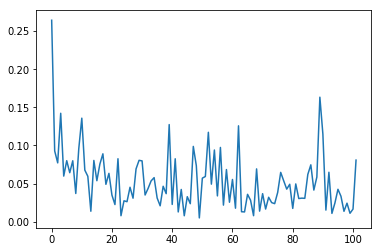

In [24]:
sts = []
for i in range(len(T)):
    sts.append(network_utils.get_stationary_distribution(T[i]))
dists = []
mean_st = np.mean(sts, axis=0)
for st in sts:
    dists.append(np.linalg.norm(st - mean_st))
plt.plot(dists);

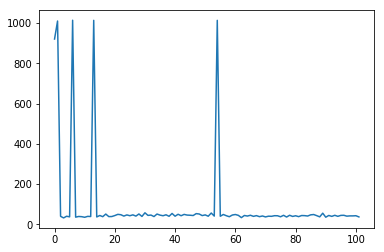

In [25]:
mts = []
for i in range(len(T)):
    mts.append(network_utils.get_mixing_time_range(T[i]))
plt.plot(mts);

In [13]:
l = len(T)
test_numbers = 10

# l = 20
# test_numbers = 5

In [14]:
l

102

In [15]:
# l = l - 1  # one less than actual value
r = obs_normalized

In [8]:
start_time = time.time()

n = 138
eps = 0.01
# lam1 = 0.5

errs = []
for test_number in np.arange(test_numbers, 0, -1):
    print(test_number)

    P = [cp.Variable(n, n) for _ in range(l - test_number - 1)]

    term1 = 0
    for i in range(1, l - test_number - 1):
        term1 += cp.norm2(P[i] - P[i - 1])

#     term2 = 0
#     for i in range(1, l - test_number - 1):
#         term2 += cp.norm1(P[i] - P[i - 1])

    objective = cp.Minimize(term1)  # + term2 * lam1)

    # Constraints.
    constraints = []
    for i in range(l - test_number - 1):
        constraints += (
            [0 < P[i],
             P[i] <= 1,
             P[i] * np.ones(n) == np.ones(n),
             r[i] * P[i] == r[i + 1],
#              r[i + 1] * P[i] == r[i + 1]])
             cp.norm2(r[i + 1] * P[i] - r[i + 1]) < eps])

    # Problem.
    prob = cp.Problem(objective, constraints)

    # Solving the problem.
    res = prob.solve(cp.MOSEK)
    err = np.linalg.norm(r[l - test_number] - (r[l - test_number - 1] * P[l - test_number - 2].value), 2)
    errs.append(err)

duration = time.time() - start_time
print('It took :{} mins.'.format(round(duration/60, 2)))
print('Errors: {} +- {}'.format(round(np.mean(errs), 4), round(np.std(errs)), 6))
print(errs)

# Baselines.
mean_errs = []
for test_number in np.arange(test_numbers, 0, -1):
    mean_err = np.linalg.norm(r[l - test_number] - np.mean(r[:l - test_number - 1], axis=0)[0], 2)
    mean_errs.append(mean_err)
last_errs = []
for test_number in np.arange(test_numbers, 0, -1):
    last_err = np.linalg.norm(r[l - test_number] - r[l - test_number - 1], 2)
    last_errs.append(last_err)
# rnd_errs = []
# for test_number in np.arange(test_numbers, 0, -1):
#     rnd_err = np.linalg.norm(r[l - test_number] - (1/138) * np.ones(138), 2)
#     rnd_errs.append(rnd_err)

10
9
8
7
6
5
4
3
2
1
It took :304.4 mins.
Errors: 0.01 +- 0.0
[0.003939345559751591, 0.01436005578564293, 0.024555757209971038, 0.006776715974825471, 0.007006613636979925, 0.005935201643805323, 0.008602038149359467, 0.005426107103007042, 0.009036325543772445, 0.013985091264246418]


Text(0,0.5,'Root Mean Square Error (RMSE)')

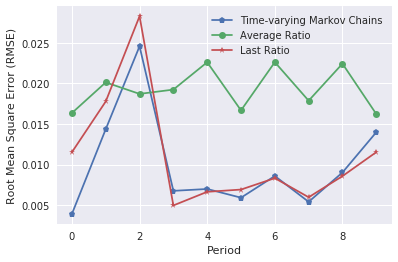

In [9]:
sns.set(rc={'figure.figsize': (6, 4)})
plt.plot(errs, '-p')
plt.plot(mean_errs, '-o')
plt.plot(last_errs, '-*')
plt.legend(['Time-varying Markov Chains', 'Average Ratio', 'Last Ratio'])
plt.xlabel('Period')
plt.ylabel('Root Mean Square Error (RMSE)')
# plt.savefig('country_RMSE_20_5.png');

# save P

In [11]:
# estimated_matrices = []
# for i in range(len(P)):
#     estimated_matrices.append(P[i].value)

# # Saves the transitions.
# with open('pickles/estimated_matrices_icew.pk', 'wb') as f:
#     pk.dump(estimated_matrices, f)

In [6]:
# Loading.
with open('pickles/estimated_matrices_icew.pk', 'rb') as f:
    estimated_matrices = pk.load(f)

In [111]:
errs

[0.01769715623490523,
 0.04914414108387373,
 0.003939345559751591,
 0.01436005578564293,
 0.024555757209971038,
 0.006776715974825471,
 0.007006613636979925,
 0.005935201643805323,
 0.008602038149359467,
 0.005426107103007042]

In [109]:
mean_errs

[0.054358615180683106,
 0.018740629968843955,
 0.016349991685442718,
 0.02011729310479176,
 0.01870151136074247,
 0.019230063517677212,
 0.022595876246880493,
 0.016673519223330366,
 0.022605376430671984,
 0.01786489266837002]

In [110]:
last_errs

[0.027108974717036247,
 0.05901652646111579,
 0.011530557049457785,
 0.017768502778529722,
 0.028251400400565077,
 0.00498261864914045,
 0.00665766317130501,
 0.006935625764094969,
 0.008337950490614919,
 0.0059899019979305895]

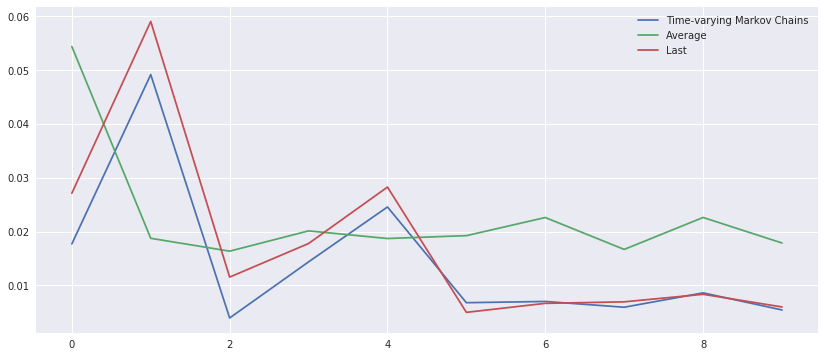

In [98]:
f = plt.figure()
plt.plot(errs)
# plt.plot(rnd_errs)
plt.plot(mean_errs)
plt.plot(last_errs)
plt.legend(['Time-varying Markov Chains', 'Average Ratio', 'Last Ratio']);

It took :4.33 mins.
Errors: 0.0304 +- 0.0
[0.02513058396184633, 0.040480677633822904, 0.014653229114282672, 0.04324212008388951, 0.02871799935719017]


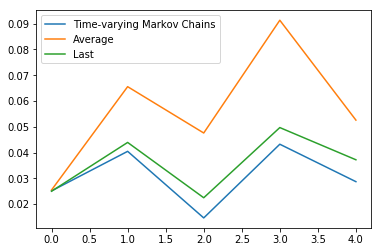

l = 10, tn = 3

norm2 with 3 test numbers with norm2( r[i + 1] * P[i] - r[i + 1] ) < eps

It took :0.73 mins.
    
Errors: 0.0188 +- 0.0
    
[0.013755268962595392, 0.010296676466642061, 0.032355268242071876]

l = 10, tn = 3

norm2 with r[i + 1] * P[i] == r[i + 1]]

It took :0.73 mins.

Errors: 0.0196 +- 0.0

[0.01451470613135414, 0.01066150620601352, 0.033668886819223885]

l = 10, tn = 3

0.5 * norm1 and norm2 with 3 test numbers with norm2( r[i + 1] * P[i] - r[i + 1] ) < eps

It took :7.17 mins.

Errors: 0.0191 +- 0.0

[0.013871543936858752, 0.010700561801106873, 0.0326669902633813]

l = 10, tn = 3

norm1 with 3 test numbers with norm2( r[i + 1] * P[i] - r[i + 1] ) < eps

It took :7.06 mins.

Errors: 0.0198 +- 0.0

[0.014775100256169692, 0.01158931803653387, 0.0331656784507608]

l = 15, tn = 3

norm2 with 3 test numbers with norm2( r[i + 1] * P[i] - r[i + 1] ) < eps

It took :1.75 mins.

Errors: 0.02 +- 0.0

[0.030233537368111404, 0.010352427211241055, 0.024087536308780952]

l = 15, tn = 3

norm2 with 3 test numbers with r[i + 1] * P[i] == r[i + 1]]

It took :1.84 mins.

Errors: 0.021174134391456965 +- 0.009946572226333857

[0.03176729638619647, 0.007862558834175212, 0.023892547953999217]

In [152]:
# BAK:

# start_time = time.time()

# n = 138
# # lam1 = 0.5
# eps = 0.01
# P = [cp.Variable(n, n) for _ in range(l-1)]

# term1 = 0
# for i in range(1, l-1):
#     term1 += cp.norm2(P[i] - P[i - 1])
    
# # term2 = 0
# # for i in range(1, l-1):
# #     term2 += cp.norm1(P[i] - P[i - 1])

# objective = cp.Minimize(term1)  # + term2 * lam1)

# # Constraints.
# constraints = []
# for i in range(l-1):
#     constraints += (
#         [0 < P[i],
#          P[i] <= 1,
#          P[i] * np.ones(n) == np.ones(n),
#         r[i] * P[i] == r[i + 1],
#          r[i + 1] * P[i] == r[i + 1]])
# #         cp.norm2(r[i + 1] * P[i] - r[i + 1]) < eps])

# # Problem.
# prob = cp.Problem(objective, constraints)

# # Solving the problem.
# res = prob.solve(cp.MOSEK)
# v = np.linalg.norm(r[l] - (r[l-1] * P[l-2].value), 2)
# print(v)

# duration = time.time() - start_time
# print('It took :{} mins.'.format(round(duration/60, 2)))

0.04979459038237021
It took :1.67 mins.


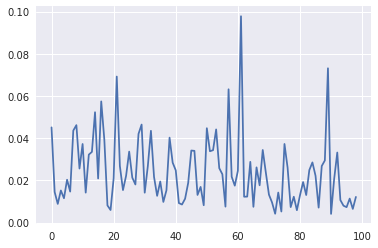

In [12]:
sns.set(rc={'figure.figsize': (6, 4)})
diff = []
for i in range(1, l-2):
    diff.append(np.linalg.norm(P[i].value - P[i-1].value))
plt.plot(diff);

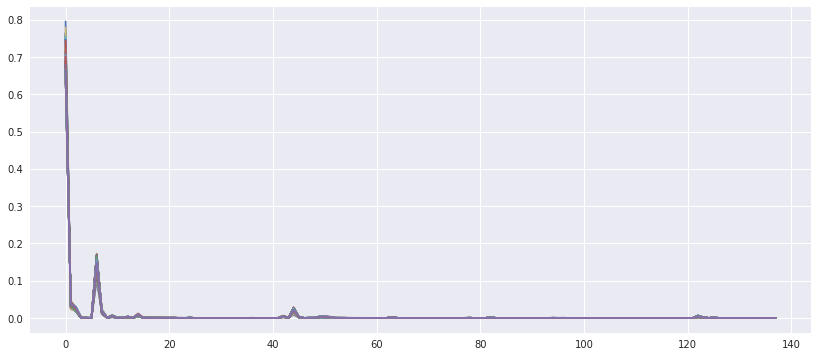

In [13]:
sns.set(rc={'figure.figsize': (14, 6)})
legends = []
for i, transition_matrix in enumerate(P):
    st_dist = network_utils.get_stationary_distribution(np.asarray(transition_matrix.value))
    plt.plot(st_dist)
#     legends.append(i)
# plt.legend(legends)

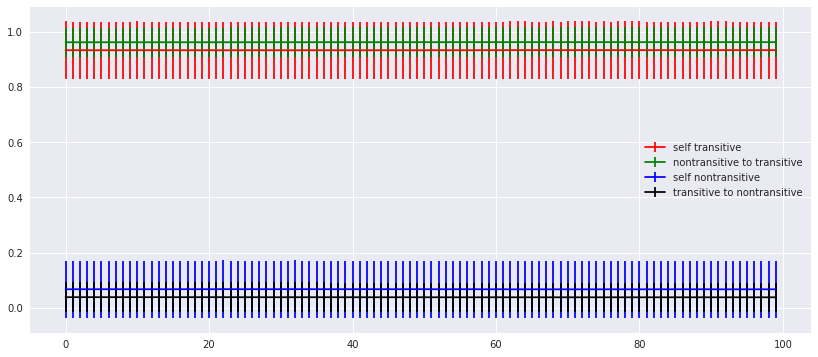

In [14]:
self_transitive_means = []
self_nontransitive_means = []
nontransitive_to_transitive_means = []
transitive_to_nontransitive_means = []
self_transitive_stds = []
self_nontransitive_stds = []
nontransitive_to_transitive_stds = []
transitive_to_nontransitive_stds = []

for matrix in P:
    trans_matrix = matrix.value
    
    probs = np.sum(trans_matrix[transitives, :][:, transitives], axis=1)
    self_transitive_means.append(np.mean(probs))
    self_transitive_stds.append(np.std(probs))

    probs = np.sum(trans_matrix[~transitives, :][:, transitives], axis=1)
    nontransitive_to_transitive_means.append(np.mean(probs))
    nontransitive_to_transitive_stds.append(np.std(probs))

    probs = np.sum(trans_matrix[~transitives, :][:, ~transitives], axis=1)
    transitive_to_nontransitive_means.append(np.mean(probs))
    transitive_to_nontransitive_stds.append(np.std(probs))

    probs = np.sum(trans_matrix[transitives, :][:, ~transitives], axis=1)
    self_nontransitive_means.append(np.mean(probs))
    self_nontransitive_stds.append(np.std(probs))
    

plt.errorbar(x=np.arange(l-2), y=self_transitive_means, yerr=self_transitive_stds, fmt='r')
plt.errorbar(x=np.arange(l-2), y=nontransitive_to_transitive_means, yerr=nontransitive_to_transitive_stds, fmt='g')
plt.errorbar(x=np.arange(l-2), y=self_nontransitive_means, yerr=self_nontransitive_stds, fmt='b')
plt.errorbar(x=np.arange(l-2), y=transitive_to_nontransitive_means, yerr=transitive_to_nontransitive_stds, fmt='k')
plt.legend(['self transitive', 'nontransitive to transitive', 'self nontransitive', 'transitive to nontransitive']);


# plt.errorbar(x=np.arange(39), y=self_transitive_means) #, yerr=self_transitive_stds)
# plt.errorbar(x=np.arange(39), y=nontransitive_to_transitive_means) #, yerr=nontransitive_to_transitive_stds)
# plt.errorbar(x=np.arange(39), y=self_nontransitive_means) #, yerr=self_nontransitive_stds)
# plt.errorbar(x=np.arange(39), y=transitive_to_nontransitive_means) #, yerr=transitive_to_nontransitive_stds)
# plt.legend(['self transitive', 'nontransitive to transitive', 'self nontransitive', 'transitive to nontransitive']);

In [6]:
trans_matrix = P[-1].value

# trans_matrix = estimated_matrices[-1]

# KDE PLOTS STARTS

/home/omid/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Transition probability of "transitive to self": 0.93 +- 0.1
Transition probability of "not transitive to transitive": 0.96 +- 0.05
Transition probability of "transitive to not transitive": 0.07 +- 0.1
Transition probability of "not transitive to self": 0.04 +- 0.05


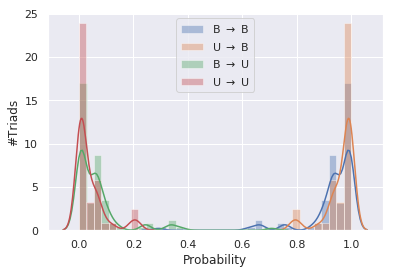

In [42]:
sns.set(rc={'figure.figsize': (6, 4)})
probs = np.sum(trans_matrix[transitives, :][:, transitives], axis=1)
sns.distplot(probs)
print('Transition probability of "transitive to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~transitives, :][:, transitives], axis=1)
sns.distplot(probs)
print('Transition probability of "not transitive to transitive": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[transitives, :][:, ~transitives], axis=1)
sns.distplot(probs)
print('Transition probability of "transitive to not transitive": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~transitives, :][:, ~transitives], axis=1)
sns.distplot(probs)
print('Transition probability of "not transitive to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

plt.xlabel('Probability')
plt.ylabel('#Triads');
plt.legend([r'B $\rightarrow$ B', r'U $\rightarrow$ B', r'B $\rightarrow$ U', r'U $\rightarrow$ U'], loc='upper center')
plt.savefig('ICEWS_transitivity_transitionprobabilities_kde.pdf');

/home/omid/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Transition probability of "C&H balance to self": 0.94 +- 0.08
Transition probability of "not C&H balance to C&H balance": 0.87 +- 0.17
Transition probability of "C&H balance to not C&H balance": 0.06 +- 0.08
Transition probability of "not C&H balance to not C&H balance": 0.13 +- 0.17


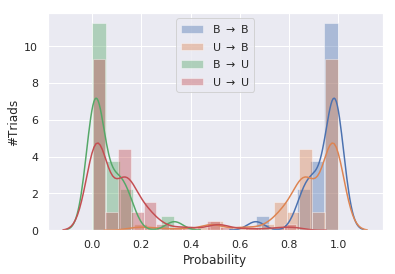

In [43]:
sns.set(rc={'figure.figsize': (6, 4)})
probs = np.sum(trans_matrix[ch, :][:, ch], axis=1)
sns.distplot(probs)
print('Transition probability of "C&H balance to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~ch, :][:, ch], axis=1)
sns.distplot(probs)
print('Transition probability of "not C&H balance to C&H balance": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[ch, :][:, ~ch], axis=1)
sns.distplot(probs)
print('Transition probability of "C&H balance to not C&H balance": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~ch, :][:, ~ch], axis=1)
sns.distplot(probs)
print('Transition probability of "not C&H balance to not C&H balance": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

plt.xlabel('Probability')
plt.ylabel('#Triads');
plt.legend([r'B $\rightarrow$ B', r'U $\rightarrow$ B', r'B $\rightarrow$ U', r'U $\rightarrow$ U'], loc='upper center')
plt.savefig('ICEWS_classical_transitionprobabilities_kde.pdf');

/home/omid/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Transition probability of "clustering to self": 0.87 +- 0.19
Transition probability of "not clustering to clustering": 0.91 +- 0.11
Transition probability of "not clustering to self": 0.09 +- 0.11
Transition probability of "clustering to not clustering": 0.13 +- 0.19


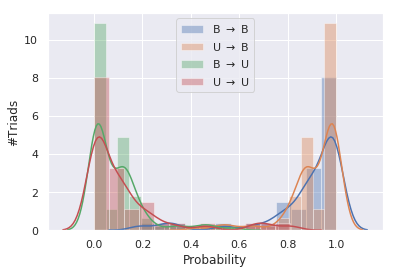

In [44]:
sns.set(rc={'figure.figsize': (6, 4)})
probs = np.sum(trans_matrix[cluster, :][:, cluster], axis=1)
sns.distplot(probs)
print('Transition probability of "clustering to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~cluster, :][:, cluster], axis=1)
sns.distplot(probs)
print('Transition probability of "not clustering to clustering": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~cluster, :][:, ~cluster], axis=1)
sns.distplot(probs)
print('Transition probability of "not clustering to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[cluster, :][:, ~cluster], axis=1)
sns.distplot(probs)
print('Transition probability of "clustering to not clustering": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

plt.xlabel('Probability')
plt.ylabel('#Triads');
plt.legend([r'B $\rightarrow$ B', r'U $\rightarrow$ B', r'B $\rightarrow$ U', r'U $\rightarrow$ U'], loc='upper center');
plt.savefig('ICEWS_clustering_transitionprobabilities_kde.pdf');

# KDE PLOTS ENDS

Transition probability of "transitive to self": 0.93 +- 0.1
Transition probability of "not transitive to transitive": 0.96 +- 0.05
Transition probability of "transitive to not transitive": 0.07 +- 0.1
Transition probability of "not transitive to self": 0.04 +- 0.05


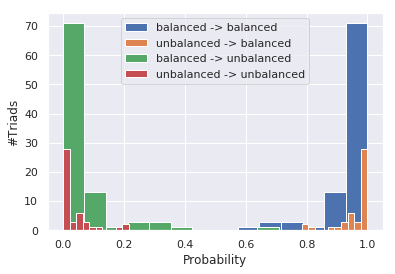

In [7]:
sns.set(rc={'figure.figsize': (6, 4)})
probs = np.sum(trans_matrix[transitives, :][:, transitives], axis=1)
plt.hist(probs)
print('Transition probability of "transitive to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~transitives, :][:, transitives], axis=1)
plt.hist(probs)
print('Transition probability of "not transitive to transitive": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[transitives, :][:, ~transitives], axis=1)
plt.hist(probs)
print('Transition probability of "transitive to not transitive": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~transitives, :][:, ~transitives], axis=1)
plt.hist(probs)
print('Transition probability of "not transitive to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

plt.xlabel('Probability')
plt.ylabel('#Triads');
plt.legend(['balanced -> balanced', 'unbalanced -> balanced', 'balanced -> unbalanced', 'unbalanced -> unbalanced'])
# plt.title('(a)', weight='bold')
plt.savefig('ICEWS_transitivity_transitionprobabilities.pdf');

Transition probability of "C&H balance to self": 0.94 +- 0.08
Transition probability of "not C&H balance to C&H balance": 0.87 +- 0.17
Transition probability of "not C&H balance to self": 0.13 +- 0.17
Transition probability of "C&H balance to not C&H balance": 0.06 +- 0.08


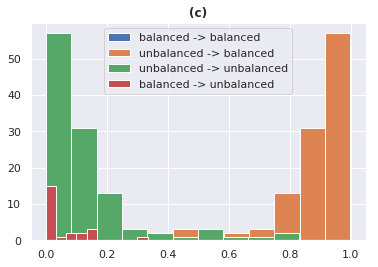

In [25]:
sns.set(rc={'figure.figsize': (6, 4)})
probs = np.sum(trans_matrix[ch, :][:, ch], axis=1)
plt.hist(probs)
print('Transition probability of "C&H balance to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~ch, :][:, ch], axis=1)
plt.hist(probs)
print('Transition probability of "not C&H balance to C&H balance": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[ch, :][:, ~ch], axis=1)
plt.hist(probs)
print('Transition probability of "C&H balance to not C&H balance": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~ch, :][:, ~ch], axis=1)
plt.hist(probs)
print('Transition probability of "not C&H balance to not C&H balance": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

plt.legend(['balanced -> balanced', 'unbalanced -> balanced', 'balanced -> unbalanced', 'unbalanced -> unbalanced'])
# plt.title('(c)', weight='bold')
plt.savefig('ICEWS_classical_transitionprobabilities.pdf');

Transition probability of "clustering to self": 0.87 +- 0.19
Transition probability of "not clustering to clustering": 0.91 +- 0.11
Transition probability of "not clustering to self": 0.09 +- 0.11
Transition probability of "clustering to not clustering": 0.13 +- 0.19


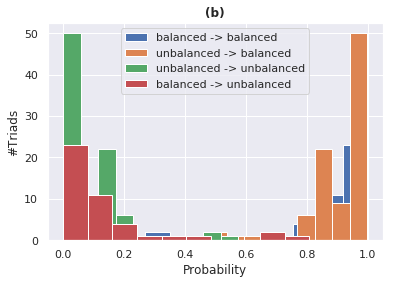

In [26]:
sns.set(rc={'figure.figsize': (6, 4)})
probs = np.sum(trans_matrix[cluster, :][:, cluster], axis=1)
plt.hist(probs)
print('Transition probability of "clustering to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~cluster, :][:, cluster], axis=1)
plt.hist(probs)
print('Transition probability of "not clustering to clustering": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~cluster, :][:, ~cluster], axis=1)
plt.hist(probs)
print('Transition probability of "not clustering to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[cluster, :][:, ~cluster], axis=1)
plt.hist(probs)
print('Transition probability of "clustering to not clustering": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

plt.xlabel('Probability')
plt.ylabel('#Triads');
plt.legend(['balanced -> balanced', 'unbalanced -> balanced', 'unbalanced -> unbalanced', 'balanced -> unbalanced'])
# plt.title('(b)', weight='bold')
plt.savefig('ICEWS_clustering_transitionprobabilities.pdf');

# Specific triads transitions in different transition probability matrices

In [49]:
def print_those(from_triad, to_triad):
    probs = []
    for l in range(len(T)):
        probs.append(
            T[l][from_triad, to_triad])
    print('{} +- {}'.format(np.mean(probs), np.std(probs)))

    probs = []
    for l in range(len(P)):
        probs.append(
            P[l].value[from_triad, to_triad])
    print('{} +- {}\n'.format(np.mean(probs), np.std(probs)))

In [51]:
# transitivity balanced
print_those(from_triad=8, to_triad=22)

#classically balanced
print_those(from_triad=18, to_triad=33)
print_those(from_triad=15, to_triad=26)
print_those(from_triad=11, to_triad=37)

0.00019729759298301366 +- 0.00046595739102024464
6.185063228984446e-05 +- 2.598023102264978e-06

0.00014147596125482247 +- 0.000546970051029424
0.0002037209366123902 +- 8.222897688121215e-06

0.00012161092849005391 +- 0.00040356812294736446
6.760166000758875e-05 +- 1.3592706873336379e-05

0.00020769686034914384 +- 0.0005957631652778768
6.633801298287697e-05 +- 3.7010217491541865e-06



In [53]:
np.where(P[-1].value > 0.99)

(array([  8,  12,  16,  24,  49,  50,  51,  63, 122, 123]),
 array([0, 0, 6, 0, 0, 0, 0, 0, 0, 0]))

In [67]:
np.where(P[-1].value[:, 22] > 0.006)

(array([ 32,  87,  91, 110, 135]), array([0, 0, 0, 0, 0]))

In [68]:
np.where(P[-1].value[:, 33] > 0.006)

(array([110]), array([0]))

In [69]:
np.where(P[-1].value[:, 26] > 0.006)

(array([110]), array([0]))

In [65]:
np.where(P[-1].value[:, 37] > 0.006)

(array([ 91, 110]), array([0, 0]))

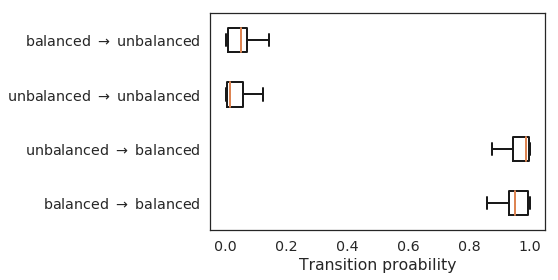

In [7]:
# reload()
# utils.plot_box_plot_for_transitions(
#     estimated_matrices[-1], transitives, True, 'ICEWS_transitivity', 'ICEWS')

reload()
sns.set(font_scale=1.3)
sns.set_style("white")
utils.plot_box_plot_for_transitions(
    estimated_matrices[-1], transitives, True, 'ICEWS_transitivity')

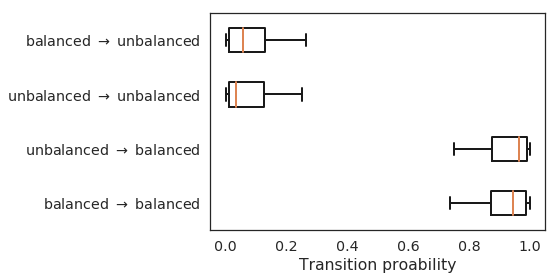

In [8]:
# reload()
# utils.plot_box_plot_for_transitions(
#     estimated_matrices[-1], cluster, True, 'ICEWS_clustering', 'ICEWS')

reload()
sns.set(font_scale=1.3)
sns.set_style("white")
utils.plot_box_plot_for_transitions(
    estimated_matrices[-1], cluster, True, 'ICEWS_clustering')

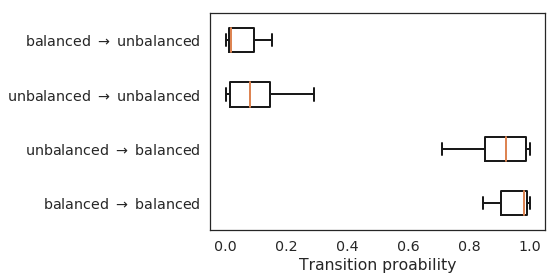

In [9]:
reload()
sns.set(font_scale=1.3)
sns.set_style("white")
utils.plot_box_plot_for_transitions(
    estimated_matrices[-1], ch, True, 'ICEWS_classical')

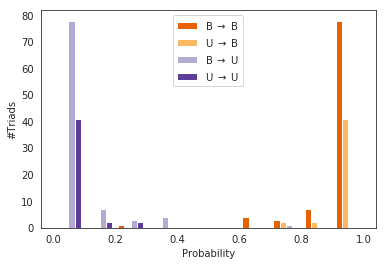

In [26]:
sns.set_style('white', rc={'figure.figsize': (6, 4)})
probs1 = np.sum(trans_matrix[transitives, :][:, transitives], axis=1)
probs2 = np.sum(trans_matrix[~transitives, :][:, transitives], axis=1)
probs3 = np.sum(trans_matrix[transitives, :][:, ~transitives], axis=1)
probs4 = np.sum(trans_matrix[~transitives, :][:, ~transitives], axis=1)

colors = ['#e66101', '#fdb863', '#b2abd2', '#5e3c99']
plt.hist([probs1, probs2, probs3, probs4], color=colors)

plt.xlabel('Probability')
plt.ylabel('#Triads');
plt.legend([r'B $\rightarrow$ B', r'U $\rightarrow$ B', r'B $\rightarrow$ U', r'U $\rightarrow$ U'], loc='upper center')
plt.savefig('ICEWS_transitivity_transitionprobabilities_binbeside.pdf');

/home/omid/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Transition probability of "clustering to self": 0.87 +- 0.19
Transition probability of "not clustering to clustering": 0.91 +- 0.11
Transition probability of "not clustering to self": 0.09 +- 0.11
Transition probability of "clustering to not clustering": 0.13 +- 0.19


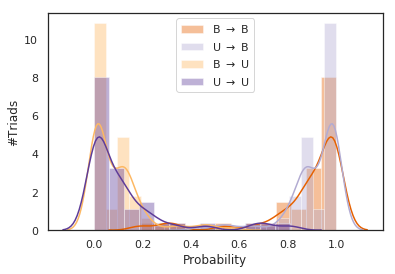

In [33]:
colors = ['#e66101', '#b2abd2', '#fdb863', '#5e3c99']

probs = np.sum(trans_matrix[cluster, :][:, cluster], axis=1)
sns.distplot(probs, color=colors[0])
print('Transition probability of "clustering to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~cluster, :][:, cluster], axis=1)
sns.distplot(probs, color=colors[1])
print('Transition probability of "not clustering to clustering": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~cluster, :][:, ~cluster], axis=1)
sns.distplot(probs, color=colors[2])
print('Transition probability of "not clustering to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[cluster, :][:, ~cluster], axis=1)
sns.distplot(probs, color=colors[3])
print('Transition probability of "clustering to not clustering": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

plt.xlabel('Probability')
plt.ylabel('#Triads');
plt.legend([r'B $\rightarrow$ B', r'U $\rightarrow$ B', r'B $\rightarrow$ U', r'U $\rightarrow$ U'], loc='upper center');

/home/omid/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


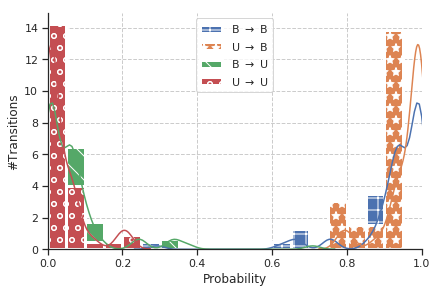

In [36]:
def set_the_hatch(bars, hatch):
    for patch in bars.patches:
        if not patch.get_hatch():
            patch.set_hatch(hatch)
            


sns.set_style('white', rc={'figure.figsize': (6, 4)})
ax = plt.gca()
bins = np.arange(0, 1, 0.05)
alpha = 1

# Define some hatches
hatches = ['-', '+', 'x', '\\', '*', 'o']

probs1 = np.sum(trans_matrix[transitives, :][:, transitives], axis=1)
probs2 = np.sum(trans_matrix[~transitives, :][:, transitives], axis=1)
probs3 = np.sum(trans_matrix[transitives, :][:, ~transitives], axis=1)
probs4 = np.sum(trans_matrix[~transitives, :][:, ~transitives], axis=1)

bars = sns.distplot(probs1, bins=bins, norm_hist=False, hist_kws={"linewidth": 3, "alpha": alpha})
set_the_hatch(bars, hatches[1])
    
bars = sns.distplot(probs2, bins=bins, norm_hist=False, hist_kws={"linewidth": 3, "alpha": alpha})
set_the_hatch(bars, hatches[4])

bars = sns.distplot(probs3, bins=bins, norm_hist=False, hist_kws={"linewidth": 3, "alpha": alpha})
set_the_hatch(bars, hatches[3])

bars = sns.distplot(probs4, bins=bins, norm_hist=False, hist_kws={"linewidth": 3, "alpha": alpha})
set_the_hatch(bars, hatches[5])

ax.set_xlim([0, 1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.xaxis.grid(b=True, which='major', linestyle='--')
ax.xaxis.grid(b=True, which='minor', linestyle=':')
ax.yaxis.grid(b=True, which='major', linestyle='--')

plt.tight_layout()

plt.xlabel('Probability')
plt.ylabel('#Transitions');
plt.legend([r'B $\rightarrow$ B', r'U $\rightarrow$ B', r'B $\rightarrow$ U', r'U $\rightarrow$ U'], loc='upper center');
plt.savefig('ICEWS_transitivity_transitionprobabilities_kde2.pdf');

/home/omid/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


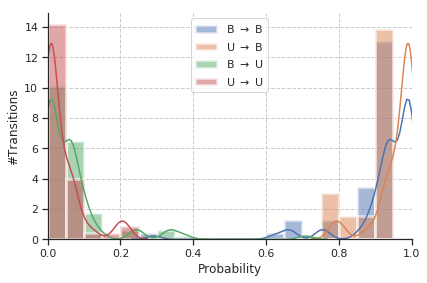

In [40]:
sns.set_style('white', rc={'figure.figsize': (6, 4)})
ax = plt.gca()
bins = np.arange(0, 1, 0.05)
alpha = 0.5

# Define some hatches
hatches = ['-', '+', 'x', '\\', '*', 'o']

probs1 = np.sum(trans_matrix[transitives, :][:, transitives], axis=1)
probs2 = np.sum(trans_matrix[~transitives, :][:, transitives], axis=1)
probs3 = np.sum(trans_matrix[transitives, :][:, ~transitives], axis=1)
probs4 = np.sum(trans_matrix[~transitives, :][:, ~transitives], axis=1)

sns.distplot(probs1, bins=bins, norm_hist=False, hist_kws={"linewidth": 3, "alpha": alpha})
sns.distplot(probs2, bins=bins, norm_hist=False, hist_kws={"linewidth": 3, "alpha": alpha})
sns.distplot(probs3, bins=bins, norm_hist=False, hist_kws={"linewidth": 3, "alpha": alpha})
sns.distplot(probs4, bins=bins, norm_hist=False, hist_kws={"linewidth": 3, "alpha": alpha})

ax.set_xlim([0, 1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.xaxis.grid(b=True, which='major', linestyle='--')
ax.xaxis.grid(b=True, which='minor', linestyle=':')
ax.yaxis.grid(b=True, which='major', linestyle='--')

plt.tight_layout(pad=1.5)

plt.xlabel('Probability')
plt.ylabel('#Transitions');
plt.legend([r'B $\rightarrow$ B', r'U $\rightarrow$ B', r'B $\rightarrow$ U', r'U $\rightarrow$ U'], loc='upper center');
plt.savefig('ICEWS_transitivity_transitionprobabilities_kde.pdf');